In [1]:
import praw
import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import sklearn
import nltk

Matplotlib created a temporary cache directory at /tmp/matplotlib-rtvczs6a because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [ ]:
clientid = ''
client_secret = ''
user_agent = ""

In [3]:
reddit = praw.Reddit(
    client_id=clientid,
    client_secret=client_secret,
    user_agent=user_agent
)

In [4]:
print(reddit.read_only)
# Output: True

True


In [5]:
import re

def find_matched_terms(text, terms):
    matched = []
    for term in terms:
        # Word-boundary search (e.g., matches "lead" but not "leadership")
        pattern = rf'\b{re.escape(term)}\b'
        if re.search(pattern, text, flags=re.IGNORECASE):
            matched.append(term)
    return matched


In [6]:
tar_sub = 'datacenter'
battery_terms = ['battery', 'batteries', 'lithium', 'li-ion', 'sodium', 'lead', 'acid', 'ups','sodium','ion']
time_filter = 'all'

In [7]:
data = []
seen_comments = set()

for term in battery_terms:
    for submission in reddit.subreddit(tar_sub).search(term, sort="top", time_filter=time_filter):
        submission.comments.replace_more(limit=0)
        for comment in submission.comments.list():
            if comment.id in seen_comments:
                continue
            text = comment.body.lower()
            matched_terms = find_matched_terms(text, battery_terms)
            if matched_terms:
                data.append({
                    'comment_id': comment.id,
                    'author': str(comment.author),
                    'text': text,
                    'matched_terms': matched_terms,
                    'submission_id': submission.id,
                    'submission_title': submission.title
                })
                seen_comments.add(comment.id)

# Convert to DataFrame
df = pd.DataFrame(data)


# Begin sentiment Analysis

- We'll use the `VADER` sentiment analyzer to conduct out sentiment analysis
    - `VADER` will score each word in the comment
        - good = + 1.9
        - good!!!! = +2.3
        - bad = - 2.5
        - Extremely Bad = -3
        - awesome = +3.1
    - Output from `VADER` will have the proprtion of posivtive and negative sentment in the text and produced a normalized value `compund`
    - We'll apply the label marking it as net positive or net negative response based on the `compound` score

In [8]:
df.head()

,comment_id,author,text,matched_terms,submission_id,submission_title
0,g0bu3y5,ghostalker47423,"do a visual inspection, and if you see any lea...",[batteries],i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...
1,g0diub1,Redebo,disconnect the battery strings via the associa...,"[battery, batteries, ups]",i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...
2,g0dtxqg,letsbebuns,the batteries should be removed based on age. ...,"[batteries, lead, acid, ups]",i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...
3,g0ebpdx,looktowindward,"yes, they are a safety hazard. you should call...",[battery],i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...
4,g0euygg,xpkranger,"i’m going to get rid of them, waiting on a quo...",[batteries],i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...


In [9]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
example = df['text'][1]
print(example)

ex_analyzer = SentimentIntensityAnalyzer()

ex_sent = ex_analyzer.polarity_scores(example)
print(ex_sent)

disconnect the battery strings via the associated battery breaker or switch that is either in the ups or electrically in line with the ups.  if you want to be safer after that, remove the intercell jumpers between each battery (caution, batteries are always 'live' and can present voltage and current when both terminals are touched).  once the batteries are disconnected and just sitting on a shelf, you can leave them there practically forever with no risk.

also, would definitely recommend rip and replace on a 15 year old ups.  if you are located in the western us, my company can assist if you're in need.
{'neg': 0.011, 'neu': 0.889, 'pos': 0.1, 'compound': 0.8366}


In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()


In [11]:
# Apply VADER to each comment's text
df['sentiment'] = df['text'].apply(lambda x: analyzer.polarity_scores(x))


In [12]:
df = pd.concat([df.drop('sentiment', axis=1), df['sentiment'].apply(pd.Series)], axis=1)


In [13]:
def get_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['compound'].apply(get_label)


In [14]:
df.head(3)

,comment_id,author,text,matched_terms,submission_id,submission_title,neg,neu,pos,compound,sentiment_label
0,g0bu3y5,ghostalker47423,"do a visual inspection, and if you see any lea...",[batteries],i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...,0.084,0.873,0.043,-0.4215,negative
1,g0diub1,Redebo,disconnect the battery strings via the associa...,"[battery, batteries, ups]",i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...,0.011,0.889,0.100,0.8366,positive
2,g0dtxqg,letsbebuns,the batteries should be removed based on age. ...,"[batteries, lead, acid, ups]",i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...,0.029,0.971,0.000,-0.2617,negative


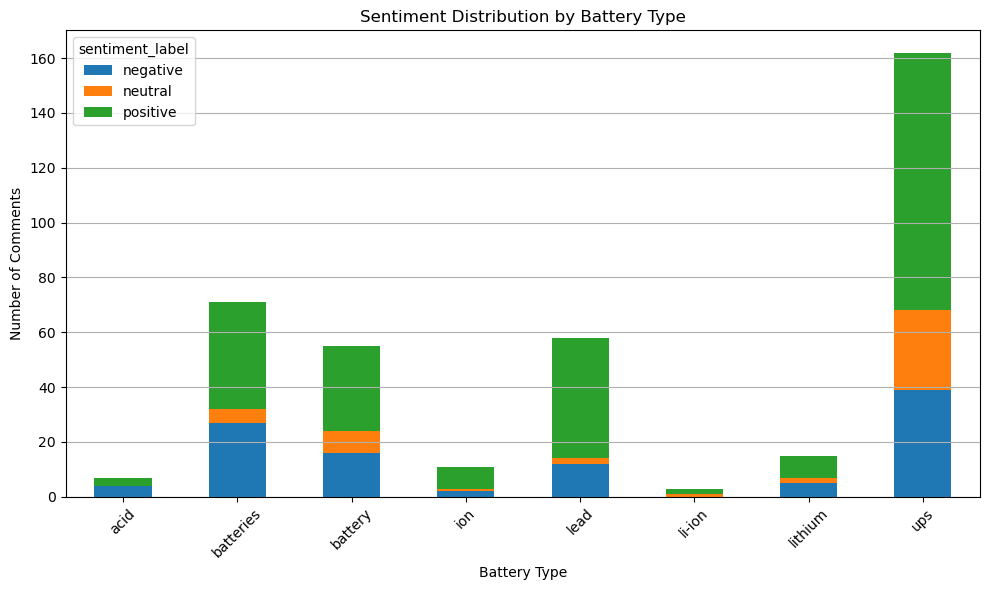

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulate a sample of the df for visualization
df_viz = pd.DataFrame({
    'matched_terms': df['matched_terms'],
    'sentiment_label': df['sentiment_label']
})
df_exploded = df_viz.explode('matched_terms')


# Explode matched_terms to allow grouping by single term
df_exploded = df_viz.explode('matched_terms')

# Count sentiment labels per battery type
sentiment_counts = df_exploded.groupby(['matched_terms', 'sentiment_label']).size().unstack(fill_value=0)

# Plot the sentiment distribution per battery type
sentiment_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sentiment Distribution by Battery Type')
plt.xlabel('Battery Type')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')

plt.show()

In [16]:
df

,comment_id,author,text,matched_terms,submission_id,submission_title,neg,neu,pos,compound,sentiment_label
0,g0bu3y5,ghostalker47423,"do a visual inspection, and if you see any lea...",[batteries],i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...,0.084,0.873,0.043,-0.4215,negative
1,g0diub1,Redebo,disconnect the battery strings via the associa...,"[battery, batteries, ups]",i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...,0.011,0.889,0.100,0.8366,positive
2,g0dtxqg,letsbebuns,the batteries should be removed based on age. ...,"[batteries, lead, acid, ups]",i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...,0.029,0.971,0.000,-0.2617,negative
3,g0ebpdx,looktowindward,"yes, they are a safety hazard. you should call...",[battery],i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...,0.000,0.718,0.282,0.6705,positive
4,g0euygg,xpkranger,"i’m going to get rid of them, waiting on a quo...",[batteries],i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...,0.000,0.807,0.193,0.7351,positive
...,...,...,...,...,...,...,...,...,...,...,...
263,frhl2ew,swedishhat,"to be fair, full 19in eia racks with ups's are...",[ups],femyhi,Does anyone here use OCP hardware in their dat...,0.000,0.944,0.056,0.7391,positive
264,kih1o5a,None,> finally adding your future generator? ah ha ...,[lead],199drs1,How can a Field Controls Engineer get PLC Prog...,0.056,0.892,0.052,-0.1779,negative
265,g9583fq,Redebo,you might ask your provider if they have some ...,[battery],jcvdpk,Floor protection in data center,0.000,0.940,0.060,0.2732,positive
266,mmhd66m,AlligatorDan,the engineering mindset on youtube is a great ...,[ups],1jw4mql,Amazon DCEO,0.013,0.827,0.160,0.9764,positive


# Hugging Face approach

In [17]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

## model is being trained on the twitter data

In [18]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [19]:
encoded_text = tokenizer(example,return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [20]:
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neutral': scores[1],
    'roberta_post': scores[2]
}

In [21]:
print(scores_dict)
print(ex_sent)

{'roberta_neg': 0.07787177, 'roberta_neutral': 0.6052092, 'roberta_post': 0.31691906}
{'neg': 0.011, 'neu': 0.889, 'pos': 0.1, 'compound': 0.8366}


In [22]:
from scipy.special import softmax

def polarity_scores_roberta(text):
    encoded_text = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,       # THIS is what prevents the crash
        max_length=512,
        padding=True
    )
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    labels = ['negative', 'neutral', 'positive']
    return labels[scores.argmax()], scores.max()


In [23]:
df[['roberta_label', 'roberta_score']] = df['text'].apply(
    lambda x: pd.Series(polarity_scores_roberta(x))
)


In [24]:
df.head(1)

,comment_id,author,text,matched_terms,submission_id,submission_title,neg,neu,pos,compound,sentiment_label,roberta_label,roberta_score
0,g0bu3y5,ghostalker47423,"do a visual inspection, and if you see any lea...",[batteries],i3jdwl,Inheriting a 30 kVA UPS with 2 strings of 24 b...,0.084,0.873,0.043,-0.4215,negative,negative,0.458596


In [25]:
df_exploded = df.explode('matched_terms')

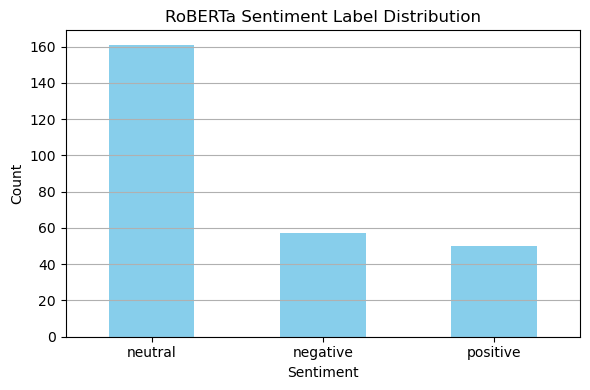

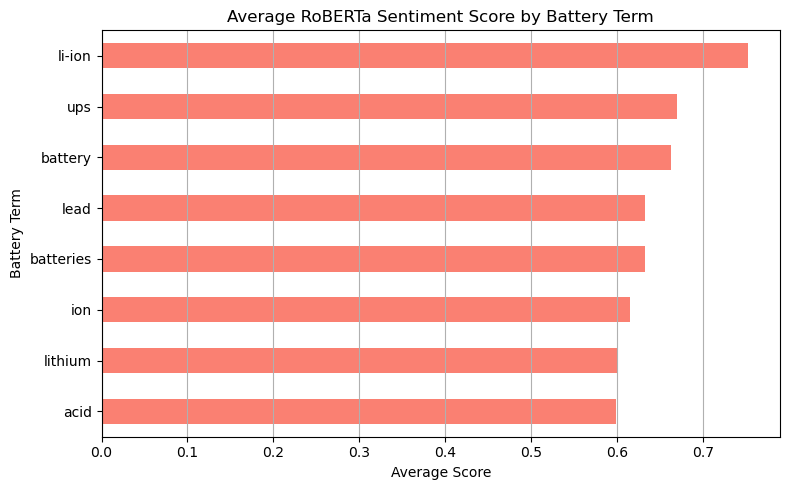

In [26]:
# Group by label to visualize distribution
label_counts = df['roberta_label'].value_counts()

# Plot sentiment label distribution
plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar', color='skyblue')
plt.title("RoBERTa Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot average sentiment score by battery type
avg_score_by_term = df_exploded.groupby('matched_terms')['roberta_score'].mean().sort_values()

plt.figure(figsize=(8, 5))
avg_score_by_term.plot(kind='barh', color='salmon')
plt.title("Average RoBERTa Sentiment Score by Battery Term")
plt.xlabel("Average Score")
plt.ylabel("Battery Term")
plt.grid(axis='x')
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

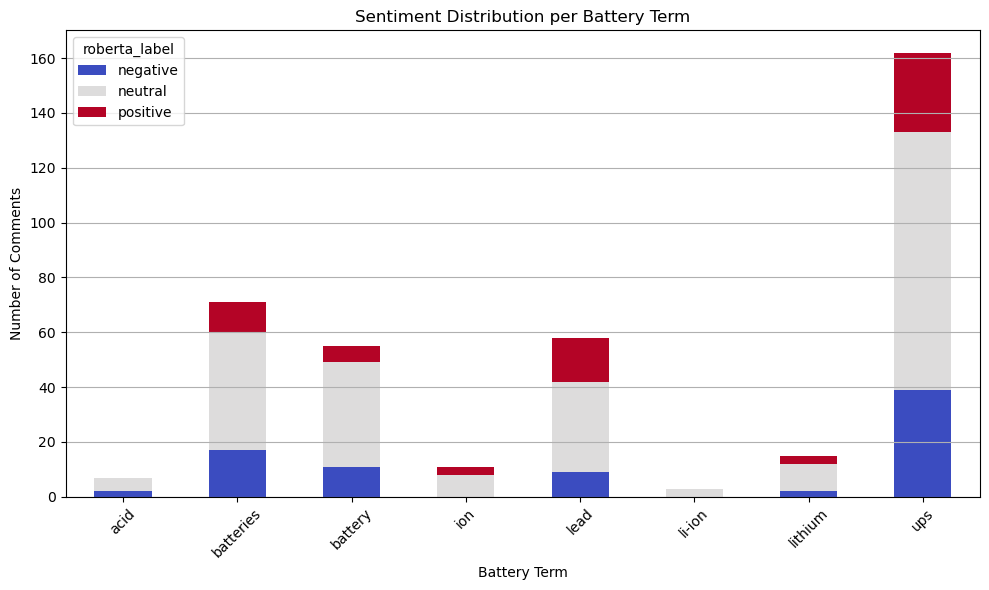

,matched_terms,text_most_positive,roberta_score_most_positive,text_most_negative,roberta_score_most_negative
0,acid,"actually, many ups', especially dc grade ups',...",0.859889,"""no such thing as a data center that's too col...",0.455056
1,batteries,that'll prove to be a disaster if the batterie...,0.945713,this may have been the consensus 5 years ago.\...,0.436103
2,battery,are all of the raid batteries the same age? an...,0.913489,i handle all field ups units for a large truck...,0.446345
3,ion,"yes, it is detailed in their site that the mv ...",0.865184,"""no such thing as a data center that's too col...",0.455056
4,lead,"first of all, taking on those data center move...",0.944411,"it really depends op, working at a dc is great...",0.407846
5,li-ion,"yes, it is detailed in their site that the mv ...",0.865184,of course it's feasible. tesla made mega batte...,0.643169
6,lithium,"actually, many ups', especially dc grade ups',...",0.859889,this may have been the consensus 5 years ago.\...,0.436103
7,ups,the engineering mindset on youtube is a great ...,0.973194,yeah i wish we got more remote hands tickets a...,0.426720


In [27]:


# ---------------------------
# Visualization by Sentiment Class and Term
# ---------------------------
sentiment_counts = df_exploded.groupby(['matched_terms', 'roberta_label']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(10, 6))
plt.title("Sentiment Distribution per Battery Term")
plt.xlabel("Battery Term")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# ---------------------------
# Drill-down: Most Positive & Negative per Term
# ---------------------------
most_pos_comments = df_exploded.sort_values(by='roberta_score', ascending=False).groupby('matched_terms').first().reset_index()
most_neg_comments = df_exploded.sort_values(by='roberta_score').groupby('matched_terms').first().reset_index()

# Combine for review
drill_df = pd.merge(
    most_pos_comments[['matched_terms', 'text', 'roberta_score']],
    most_neg_comments[['matched_terms', 'text', 'roberta_score']],
    on='matched_terms',
    suffixes=('_most_positive', '_most_negative')
)
display(drill_df)

In [28]:
neg_comments = df_exploded[df_exploded['roberta_label'] == 'negative']
neg_lithium = neg_comments[neg_comments['matched_terms'] == 'lithium']



In [29]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')  # keeps only words, removes punctuation

def extract_keywords_no_punkt(text_series):
    all_words = []
    for text in text_series:
        tokens = tokenizer.tokenize(text.lower())
        filtered = [word for word in tokens if word not in stop_words]
        all_words.extend(filtered)
    return Counter(all_words).most_common(20)


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


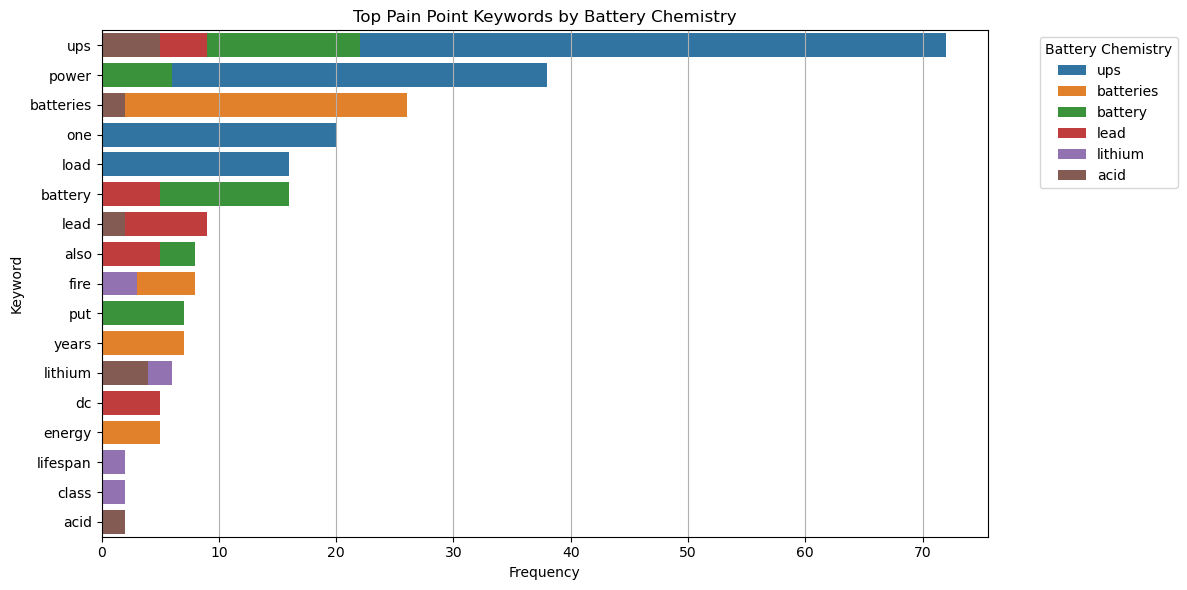

In [ ]:
# Define stop_words using NLTK's built-in list
from nltk.corpus import stopwords


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Now that stop_words is defined, rerun the visualization block
from nltk.tokenize import RegexpTokenizer
from collections import Counter

tokenizer = RegexpTokenizer(r'\w+')

def extract_keywords_no_punkt(text_series):
    all_words = []
    for text in text_series:
        tokens = tokenizer.tokenize(text.lower())
        filtered = [word for word in tokens if word not in stop_words]
        all_words.extend(filtered)
    return Counter(all_words).most_common(20)

chemistry_pain_points = {}

battery_terms = neg_comments['matched_terms'].unique()

for term in battery_terms:
    chem_comments = neg_comments[neg_comments['matched_terms'] == term]
    keywords = extract_keywords_no_punkt(chem_comments['text'])
    chemistry_pain_points[term] = keywords

pain_point_data = []

for term, keywords in chemistry_pain_points.items():
    for word, freq in keywords:
        pain_point_data.append({'battery_chemistry': term, 'keyword': word, 'frequency': freq})

pain_point_df = pd.DataFrame(pain_point_data)

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt

top_pain_points = (
    pain_point_df
    .sort_values(by='frequency', ascending=False)
    .groupby('battery_chemistry')
    .head(5)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_pain_points,
    y='keyword',
    x='frequency',
    hue='battery_chemistry',
    dodge=False
)
plt.title('Top Pain Point Keywords by Battery Chemistry')
plt.xlabel('Frequency')
plt.ylabel('Keyword')
plt.legend(title='Battery Chemistry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='x')
plt.show()
